## Problem statement: 

### To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Import Skin Cancer data

In [ ]:
import warnings
warnings.filterwarnings('ignore')
#Importing needed libraries to python
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
from keras.applications import InceptionV3
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir_train = pathlib.Path('/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define image width and height and batch size

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### We are using 80% of the images for training, and 20% for validation.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,labels='inferred',batch_size=32,
                          image_size=(img_height,img_width),seed=123,validation_split=0.2,subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,labels='inferred',batch_size=32,
                          image_size=(img_height,img_width),seed=123,validation_split=0.2,subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


### Listing the class names as a list

In [ ]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data 

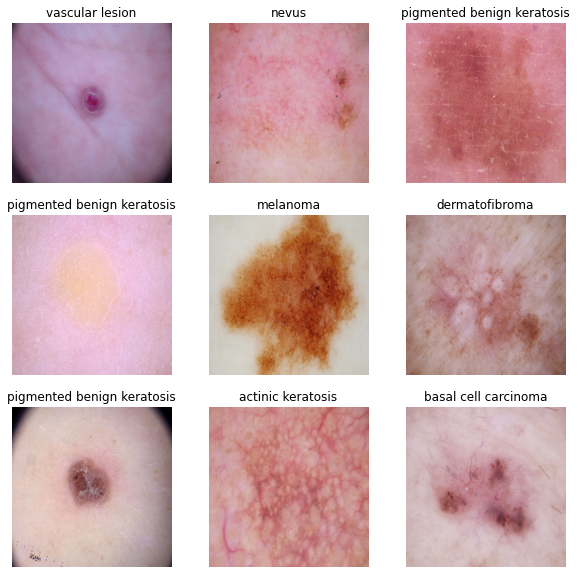

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#### The image_batch is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Normalize the data - We will rescale 1./255 to transform every pixel from range 0-255 to 0-1

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]


In [ ]:
print(np.min(first_image), np.max(first_image))

0.018201984 0.80238336


### Create a CNN model

In [ ]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(9, activation= 'softmax')
])

### Compile the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

###Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 177s 3s/step - loss: 2.0879 - accuracy: 0.2067 - val_loss: 1.8965 - val_accuracy: 0.2774
Epoch 2/20
56/56 [==============================] - 1s 20ms/step - loss: 1.7487 - accuracy: 0.3933 - val_loss: 1.5579 - val_accuracy: 0.4609
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.4742 - accuracy: 0.4831 - val_loss: 1.4070 - val_accuracy: 0.5414
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2440 - accuracy: 0.5715 - val_loss: 1.4031 - val_accuracy: 0.5548
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 1.1824 - accuracy: 0.5827 - val_loss: 1.4932 - val_accuracy: 0.5168
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.1092 - accuracy: 0.6254 - val_loss: 1.4013 - val_accuracy: 0.5235
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 0.9713 - accuracy: 0.6564 - val_loss: 1.4942 - val_accuracy: 0.5213
Epoch 8/20
56

###Visualizing training results for model #1

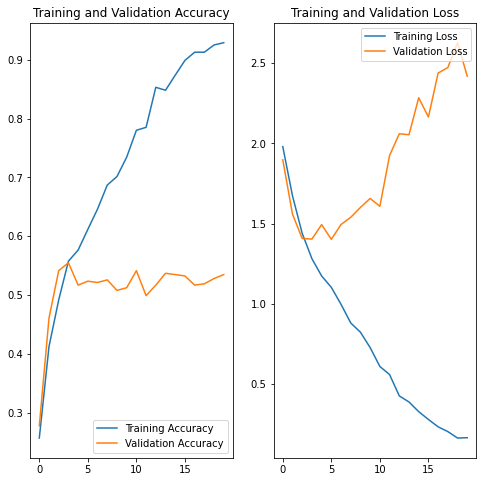

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model accuracy for training data is 91% but for validation data is 53%
Our model is overfitted, we will use data augmentation

### Data augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

###Visualizing same image by applying data augmentation

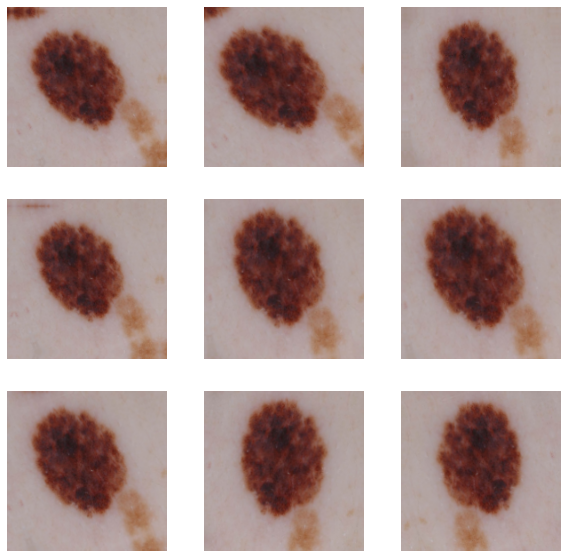

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Create the model again


In [ ]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
 
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(9, activation= 'softmax')
])



###Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

###Training the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 24ms/step - loss: 3.0348 - accuracy: 0.1936 - val_loss: 1.9696 - val_accuracy: 0.2796
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.8246 - accuracy: 0.3514 - val_loss: 1.6754 - val_accuracy: 0.4452
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.6307 - accuracy: 0.4230 - val_loss: 1.6183 - val_accuracy: 0.4251
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.5099 - accuracy: 0.4745 - val_loss: 1.6148 - val_accuracy: 0.4273
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4648 - accuracy: 0.4719 - val_loss: 1.4111 - val_accuracy: 0.5369
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3707 - accuracy: 0.5169 - val_loss: 1.4175 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2923 - accuracy: 0.5495 - val_loss: 1.3839 - val_accuracy: 0.5481
Epoch 8/20
56

### Visualizing the results

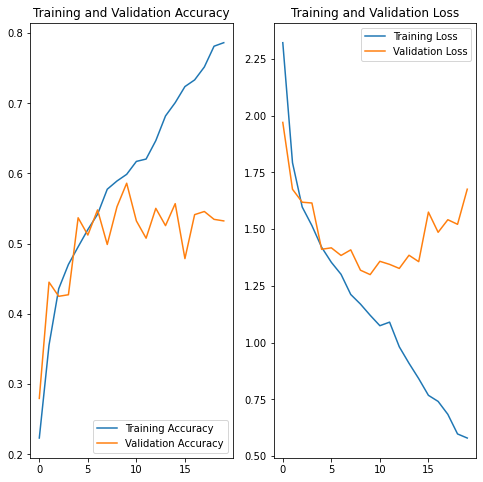

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###Model accuracy for the train_ds is 80% and for val_ds is 52%
Model is still overfitted

#### Find the class imbalance and rectify
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

#### Checking the distribution of classes in the training dataset

In [ ]:
for i in class_names:
    directory ='/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'+i+'/'
    os.chdir(directory)
    length=len(glob('*'))
    os.chdir('../..')
    print(f'{i} contains {length}')

actinic keratosis contains 114
basal cell carcinoma contains 376
dermatofibroma contains 95
melanoma contains 438
nevus contains 357
pigmented benign keratosis contains 462
seborrheic keratosis contains 77
squamous cell carcinoma contains 181
vascular lesion contains 139


#### seborrheic keratosis contains 77 samples with is the least 
#### dermatofibroma contains 95 samples which is second least 
#### The highest number of samples are of pigmented benign keratosis 462
#### Second highest is melanoma containing 438 samples


In [ ]:
path_list_original = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list_original

['/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0024446.jpg',
 '/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0024505.jpg',
 '/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0024547.jpg',
 '/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0024490.jpg',
 '/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0024495.jpg',
 '/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0024435.jpg',
 '/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0024494.jpg',
 '/content/drive/My 

In [ ]:
lesion_list_original = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_original

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [ ]:
dataframe_dict_original = dict(zip(path_list_original, lesion_list_original))

In [ ]:
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])

#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


#### We are adding 500 samples per class to make sure that none of the classes are sparse.

In [ ]:
path_to_training_dataset='/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1DEE332B10>: 100%|██████████| 500/500 [00:19<00:00, 25.91 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1DE6905490>:   0%|          | 2/500 [00:00<01:11,  7.00 Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1DDC71FF50>: 100%|██████████| 500/500 [00:18<00:00, 27.35 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1DDC76EF90>: 100%|██████████| 500/500 [00:18<00:00, 26.63 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1DDC6BAB90>: 100%|██████████| 500/500 [01:18<00:00,  6.37 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0x7F1DDC729590>: 100%|██████████| 500/500 [01:12<00:00,  6.94 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1DDC77F4D0>: 100%|██████████| 500/500 [00:20<00:00, 24.91 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F1DDC765050>: 100%|██████████| 500/500 [00:42<00:00, 11.86 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1DDC77F790>:   0%|          | 1/500 [00:00<00:53,  9.34 Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1DDC75A650>: 100%|██████████| 500/500 [00:19<00:00, 26.28 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1DE6030150>:   1%|          | 4/500 [00:00<00:52,  9.42 Samples/s]                  

Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1DDC7CF190>: 100%|██████████| 500/500 [00:19<00:00, 26.20 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


#### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027194.jpg_b3f820da-8695-4dc9-9b9f-36eb13744ba5.jpg',
 '/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027332.jpg_e41da7c6-b621-458d-8cbb-65422235a16e.jpg',
 '/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026107.jpg_e14b176f-abbd-47e6-b741-43a92216c686.jpg',
 '/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028258.jpg_e585edfd-e914-4985-a940-73aa91b8f493.jpg',
 '/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented 

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64



- So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

### Create a training dataset

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred',
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


###Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred',
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


###Normalize the data - Add why you have done rescaling

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]


In [ ]:
print(np.min(first_image), np.max(first_image))

0.30114406 0.9253276


#### Compile your model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

### Train your model with 30 epochs

In [ ]:
epochs = 30
history =  model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 40s 228ms/step - loss: 0.8993 - accuracy: 0.6894 - val_loss: 0.7911 - val_accuracy: 0.7001
Epoch 2/30
169/169 [==============================] - 39s 223ms/step - loss: 0.6568 - accuracy: 0.7616 - val_loss: 0.7133 - val_accuracy: 0.7513
Epoch 3/30
169/169 [==============================] - 39s 225ms/step - loss: 0.5215 - accuracy: 0.8098 - val_loss: 0.6389 - val_accuracy: 0.7810
Epoch 4/30
169/169 [==============================] - 39s 226ms/step - loss: 0.4058 - accuracy: 0.8538 - val_loss: 0.5601 - val_accuracy: 0.7996
Epoch 5/30
169/169 [==============================] - 39s 223ms/step - loss: 0.3329 - accuracy: 0.8774 - val_loss: 0.5827 - val_accuracy: 0.8114
Epoch 6/30
169/169 [==============================] - 39s 222ms/step - loss: 0.2831 - accuracy: 0.8927 - val_loss: 0.5776 - val_accuracy: 0.8181
Epoch 7/30
169/169 [==============================] - 39s 224ms/step - loss: 0.2757 - accuracy: 0.8992 - val_loss: 0.6356 - val_ac

#### Visualize the model results of the model #3

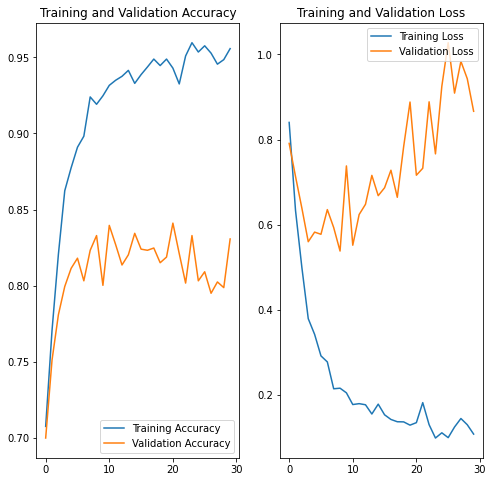

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The accuracy for train_ds is 94% while for val_ds is  83%, 
#### The overfitting issue has been solved


